# AGU Combined Analysis

In [111]:
import os
import subprocess
import sys
# import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3
from IPython.display import IFrame

from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np
import seaborn as sns

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj

/usr/local/grass85


In [126]:
class RasterStats:
    def __init__(self, univar):
        for key, value in univar.items():
            setattr(self, key, value)


class Site:
    gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
    mapset = 'PERMANENT'
    scalars = [0.25, 0.5, 1, 2, 4]
    resolutions = [1, 3, 5, 10, 30]

    # Series methods
    methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
    
    # 1st Order Togographic Derivative
    elevation = "elevation"


    hillshade = "hillshade@basic"

    # 2nd Order Topographic Derivatives
    slope = "slope@basic"
    aspect = "aspect@basic"
    pcurv = "pcurv@basic"
    tcurv = "tcurv@basic"

    # Terrain Morphology
    geomorphons = "geomorphons"

    # Terrain Ruggedness Index
    tri = "tri"
    ars = None

    # Stats
    univar = {}

    def __init__(self, site):
        self.naip_year = site['naip']
        self.site = site['site']
        self.epsg = site['crs']
        self.resolution = site['res']
        self.ortho = f"naip_{self.naip_year}_rgb@naip"
        self.ndvi = f"naip_{self.naip_year}_ndvi@basic"

        self._start_grass_session()

    def _start_grass_session(self):
        # gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
        gj.init(self.gisdb, self.site, self.mapset)
        gs.run_command("g.region", flags='a', res=self.resolution, raster=self.elevation)

    def __str__(self):
        return f"Site: {self.site}, CRS: {self.epsg}, Resolution: {self.resolution}m, NAIP: {self.naip_year}"
    
    def _scalars_as_strings(self):
        scalar_strs = [str(scalar).replace(".", "") for scalar in self.scalars]
        return scalar_strs

    def univar_stats(self, input_map):
        """Get raster statistics"""
        # if self.univar.get(input_map):
        #     return self.univar[input_map]
        
        json_data = gs.parse_command('r.univar', map=input_map, flags='e', format='json')

        self.univar[input_map] = RasterStats(json_data[0])

        return self.univar[input_map]

    def get_sim_info(self, map_name):
        sim_info = gs.parse_command("r.info", map=map_name, format="json")
        # print(sim_info['comments'])
        metadata = sim_info['comments'].split('\n\n')[0]
        parsed_info = metadata.replace('\n', ',').split(',')
        parsed_dict = {item.split('=')[0].strip(): item.split('=')[1].strip() for item in parsed_info}
        for key, value in parsed_dict.items():
            try:
                parsed_dict[key] = int(value) if value.isdigit() else float(value)
            except ValueError:
                pass  # Keep as string if conversion fails

        parsed_dict['Location'] = sim_info['location']
        parsed_dict['map_name'] = sim_info['map']
        parsed_dict['Cells'] = sim_info['cells']
        parsed_dict['Min Elevation (m)'] = sim_info['min']
        parsed_dict['Max Elevation (m)'] = sim_info['max']

        return parsed_dict
    
    def _univar_stats_df(self, mapset, raster_list, res, scalar_str, method, ars):
        df_metadata = self.fetch_sensitivity_analysis(mapset)
        df_metadata['area_m2'] = df_metadata['cells'] * df_metadata['resolution'] ** 2
        df_metadata['area_km2'] = df_metadata['area_m2'] / 1e6
        # df_metadata["p_density"] = df_metadata["particles"] / df_metadata["cells"]
        # df_metadata["error"] = 1.0 / np.sqrt(df_metadata["particles"])

        df_grouped = (
            df_metadata
                .groupby(by=['resolution', 'scalar'])
                .agg({
                        'run_time': 'mean',
                        # 'run_time': 'std',
                        'particles': 'max',
                        'cells': 'max',
                        'area_km2': 'max',
                        # 'p_density': 'max',
                        # 'error': "mean"
                    })
                    .reset_index()
        )
        stats_list = []
        for raster in raster_list.split(","):
            gs.run_command("g.region", raster=raster, flags="a")
            stats = gs.parse_command("r.univar", map=raster, format="json", flags="e")[0]
            
 
            extra_stats = df_grouped.query(f"resolution == {res} and scalar == {scalar_str.replace('0', '0.')}")
            stats["run_time"] = extra_stats["run_time"].values[0]
            stats["particles"] = extra_stats["particles"].values[0]
            stats["area_km2"] = extra_stats["area_km2"].values[0]
            stats["resolution"] = res
            stats["scalar"] = scalar_str
            stats["minute"] = raster.split("_")[4]
            stats["stat_type"] = method
            stats["ars"] = ars
            stats_list.append(stats)
        
        return pd.DataFrame(stats_list)

    def get_stdrs_rasters(self, input_strds):
        raster_depth_list = gs.parse_command(
            "t.rast.list",
            input=input_strds,
            format="json"
        )
        raster_depth_list= ",".join([m['name'] for m in raster_depth_list['data']])
        return raster_depth_list
        
    def depth_analysis(self, mapset, save_to_csv=False):
        """Depth analysis"""
        # methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
        dataframe_list = []
        scalar_strs = self._scalars_as_strings()
        for res in self.resolutions:
            gj.init(self.gisdb, self.site, mapset)
            ars_map = f"ars_{res}"
            gs.run_command("g.region", raster=f"elevation_{res}", flags="a")
            gs.run_command("r.tri", input=f"elevation_{res}", output=ars_map, size=13, processes=6, overwrite=True)
            json_data = gs.parse_command('r.univar', map=ars_map, format='json')
            ars = None
            try:
                ars = json_data[0]['mean']
            except KeyError as e:
                print(f"Error: {e}", json_data)
                ars = float('nan')

            for scalar_str in scalar_strs:
                for method in self.methods.split(","):
                    print(f"Processing: {self.site}: {res}, {scalar_str}, {method}")
                    depth_average = f"depth_{res}_{scalar_str}_s_{method}"
                    raster_depth_list=  self.get_stdrs_rasters(depth_average)
                    depth_stats_df = self._univar_stats_df(mapset, raster_depth_list, res, scalar_str, method, ars)
                    dataframe_list.append(depth_stats_df)

        result_vertical = pd.concat(dataframe_list)
        result_vertical["error"] = 1.0 / np.sqrt(result_vertical["particles"])

        # Normalize the error relative to the base case (e.g., scalar = 1)
        # base_error = result_vertical[result_vertical["scalar"] == '1']["error"].values
        # result_vertical["run_id"] = result_vertical['resolution'].astype(str) + "_" + result_vertical['scalar'].astype(str)
        # result_vertical["normalized_error"] = result_vertical["error"] / base_error[0]
        # result_vertical["p_density"] = result_vertical["particles"] / result_vertical["cells"]
        if save_to_csv:
            result_vertical.to_csv(os.path.join("../output", self.site, mapset, save_to_csv))
        return result_vertical
    
    def area(self, unit='m2'):
        """Calculate area of site"""

        resolution = float(self.resolution)

        if unit == 'm2':
            return (self.univar_stats(self.elevation).n * resolution**2)
        if unit == 'km2':
            return (self.univar_stats(self.elevation).n * resolution**2) / 1e6
        if unit == 'acres':
            return (self.univar_stats(self.elevation).n * resolution**2) / 4046.86
        return None
    
    def area_ruggedness_scale(self):
        """Calculate area ruggedness scale"""
        # if self.ars:
        #     return self.ars
        
        gs.run_command("r.tri", input=self.elevation, output=self.tri, size=15, processes=6, overwrite=True)
        json_data = gs.parse_command('r.univar', map=self.tri, flags='e', format='json')
        self.ars = json_data[0]['mean']
        return self.ars
    
    def fetch_sensitivity_analysis(self, mapset):
        """Fetch sensitivity analysis results"""
        # file_location = os.path.join("../output", self.site, mapset, 'metadata_analysis_1.csv')
        # file_location = os.path.join("../output", self.site, mapset, 'metadata_depth_analysis_1.csv')
        file_location = os.path.join("../output", self.site, mapset, 'sensitivity_analysis_1.csv')
        
        # print(f"Reading sensitity analysis from: {file_location}")
        if os.path.isfile(file_location):
            df = pd.read_csv(file_location)
            return df
        
        return None
    
def get_single_simulation_info(site, mapset, res, scalar_str, run_id ):
    gj.init(site.gisdb, site.site, mapset)
    gs.run_command("g.region", raster=site.elevation, flags="a")
    depth_average = f"depth_sum_{res}_{scalar_str}_{run_id}"
    depth_strds_name =  site.get_stdrs_rasters(depth_average)
    temp_list = []
    for output_step_name in depth_strds_name.split(","):
        run_info = site.get_sim_info(output_step_name)

        # Rename Fields
        run_info['Seed'] = run_id
        run_info['Resolution (m)'] = res
        run_info['scalar_str'] = scalar_str
        run_info['Number of iterations (cells)'] = run_info.pop('time-serie iteration')
        run_info['Mean flow velocity (m/s)'] = run_info.pop('mean vel.')
        run_info['Time Step (s)'] = run_info.pop('written deltap')
        run_info['Mean Source Rate (Rain Fall Excess) (m/s)'] = run_info.pop('mean source (si)')
        # print(f"Run Info: {output_step_name}")
        temp_list.append(run_info)

    stats_df = pd.DataFrame(temp_list)
        # for key, value in run_info.items():
        #     print(f"{key}: {value}")
            # df_sensitivity_analysis.at[index, key] = value    
            
    return stats_df
    
def threshold_label(threshold):
    if 1000 <= threshold < 1000000:
        return f"{threshold/1000:g}k"
    return str(threshold)

def basin_threshold_estimate(cells, target_basin_cells):
    num_basins = cells / target_basin_cells
    print(f"Number of Basins: {num_basins}")
    estimated_threshold = int(cells / num_basins)
    return estimated_threshold
    
output_dir = os.path.join("..", "output", "agu2024")

In [102]:
threshold = threshold_label(250)
print(threshold)

estimated_threshold = basin_threshold_estimate(1000000, 20000)
print(estimated_threshold)

250
Number of Basins: 50.0
20000


In [104]:
tes_site = Site({"site": "clay-center", "crs": "32614", "res": "3", "naip": 2021})
stats_df = get_single_simulation_info(tes_site, 'sensitivity_6', 1, "025", "1")
stats_df.head()

init.walk  maxwalk  remaining walkers  duration (sec.)  mean infil  \
0     193550    48391             186182             1800         0.0   
1     193550    48391             184664             1800         0.0   
2     193550    48391             181154             1800         0.0   
3     193550    48391             177076             1800         0.0   
4     193550    48391             166420             1800         0.0   

      Location          map_name   Cells  Min Elevation (m)  \
0  clay-center  depth_1_025_1.05  452244           0.000387   
1  clay-center  depth_1_025_1.10  452244           0.000387   
2  clay-center  depth_1_025_1.15  452244           0.000387   
3  clay-center  depth_1_025_1.20  452244           0.000387   
4  clay-center  depth_1_025_1.25  452244           0.000387   

   Max Elevation (m) Seed  Resolution (m) Particle Density  \
0           0.375271    1               1              025   
1           0.461461    1               1              025   
2           0.501729    1               1              025   
3           0.531074    1               1              025   
4           0.559280    1               1              025   

   Number of iterations (cells)  Mean flow velocity (m/s)  Time Step (s)  \
0                           299                  0.844487       0.296038   
1                           599                  0.844487       0.296038   
2                           898                  0.844487       0.296038   
3                          1198                  0.844487       0.296038   
4                          1497                  0.844487       0.296038   

   Mean Source Rate (Rain Fall Excess) (m/s)  
0                                   0.000006  
1                                   0.000006  
2                                   0.000006  
3                                   0.000006  
4                                   0.000006

In [127]:
SITE_PARAMS = [
    {"site": "clay-center", "crs": "32614", "res": "3", "naip": 2021},
    # {"site": "coweeta", "crs": "26917", "res": "10", "naip": 2022},
    # {"site": "SFREC", "crs": "26910", "res": "1", "naip": 2022},
    # {"site": "SJER", "crs": "26911", "res": "1", "naip": 2022},
    # {"site": "tx069-playas", "crs": "32613", "res": "8", "naip": 2022},
]

def combine_simulations(mapset):
    combined_df = []
    for site_param in SITE_PARAMS:
        site = Site(site_param)
        try:
            df_sensitivity_analysis = site.fetch_sensitivity_analysis(mapset)
            for index, row in df_sensitivity_analysis.iterrows():
                res = row['resolution']
                scalar_str = str(row['scalar']).replace("0.", "0").replace(".0", "")
                run_id = row['run_n']
                try:
                    stats_df = get_single_simulation_info(site, mapset, res, scalar_str, run_id)
                    stats_df['run_time'] = row['run_time']
                    stats_df['particles'] = row['particles']
                    stats_df['Particle Density'] = row['scalar']
                    stats_df['Area (km2)'] = row['area_km2']
                    combined_df.append(stats_df)
                except Exception as e:
                    # print(f"Error: {e}")
                    pass
        except Exception as e:
            # print(f"Error: {e}")
            pass

        return pd.concat(combined_df)

def combine_dataframe():
    combine_df = []
    sensitivity_mapset = 'sensitivity_1'
    for site_param in SITE_PARAMS:
        print(f"{'#' * 50}\n")
        site = Site(site_param)
        print(site)
        univar = site.univar_stats("elevation")
        print(f"""
              Area (km2): {site.area(unit='km2')}
              n: {univar.n}
              Cells: {univar.cells}
              Min: {univar.min} Max: {univar.max}
              Range: {univar.range}
              Mean: {univar.mean}
              Median: {univar.median}
              Std: {univar.stddev}
        """)
        ars = site.area_ruggedness_scale()
        print(f"ARS: {ars}")
        df_sensitivity_analysis = site.fetch_sensitivity_analysis(sensitivity_mapset)
        gj.init(os.path.join(os.getenv('HOME'), 'grassdata'), site.site, sensitivity_mapset)

        for index, row in df_sensitivity_analysis.iterrows():
            print(row)
            res = row['resolution']
            scalar_str = str(row['scalar']).replace("0.", "0").replace(".0", "")
            run_n = row['run_n']
            depth_strds_name = f"depth_{res}_{scalar_str}_{run_n}.05"
            # disch_strds_name = f"disch_sum_{res}_{scalar_str}_{run_n}.30"
            run_info = site.get_sim_info(depth_strds_name)
            for key, value in run_info.items():
                df_sensitivity_analysis.at[index, key] = value
            if df_sensitivity_analysis is not None:
                combine_df.append(df_sensitivity_analysis)

        # df = site.depth_analysis(sensitivity_mapset, save_to_csv='metadata_depth_analysis_1.csv')
        # df['site_name'] = site.site
        # df['std'] = univar.stddev
        # if df is not None:
        #     combine_df.append(df)

        results = pd.concat(combine_df)
        
    return results

# results_df = combine_dataframe()
# model_runs_df = combine_dataframe()
    # df_metadata.to_csv(os.path.join("../output", site, mapset, 'metadata_analysis_1.csv'))
model_runs_df = combine_simulations('sensitivity_7')

ValueError: No objects to concatenate

In [125]:
model_runs_df.head()

init.walk  maxwalk  remaining walkers  duration (sec.)  mean man  \
0     201570    50397             192047             7200  0.232658   
1     201570    50397             184588             7200  0.232658   
2     201570    50397             160209             7200  0.232658   
3     201570    50397             137672             7200  0.232658   
4     201570    50397             120380             7200  0.232658   

   mean infil     Location           map_name   Cells  Min Elevation (m)  \
0         0.0  clay-center  depth_1_025_0.010  468969           0.000387   
1         0.0  clay-center  depth_1_025_0.020  468969           0.000387   
2         0.0  clay-center  depth_1_025_0.030  468969           0.000387   
3         0.0  clay-center  depth_1_025_0.040  468969           0.000387   
4         0.0  clay-center  depth_1_025_0.050  468969           0.000387   

   Max Elevation (m)  Seed  Resolution (m) Particle Density  \
0           0.461002     0               1              025   
1           0.530256     0               1              025   
2           0.584766     0               1              025   
3           0.638106     0               1              025   
4           0.689599     0               1              025   

   Number of iterations (cells)  Mean flow velocity (m/s)  Time Step (s)  \
0                           598                  0.846637       0.295286   
1                          1197                  0.846637       0.295286   
2                          1796                  0.846637       0.295286   
3                          2395                  0.846637       0.295286   
4                          2994                  0.846637       0.295286   

   Mean Source Rate (Rain Fall Excess) (m/s)   run_time  particles  
0                                   0.000006  101.65646   50397.25  
1                                   0.000006  101.65646   50397.25  
2                                   0.000006  101.65646   50397.25  
3                                   0.000006  101.65646   50397.25  
4                                   0.000006  101.65646   50397.25

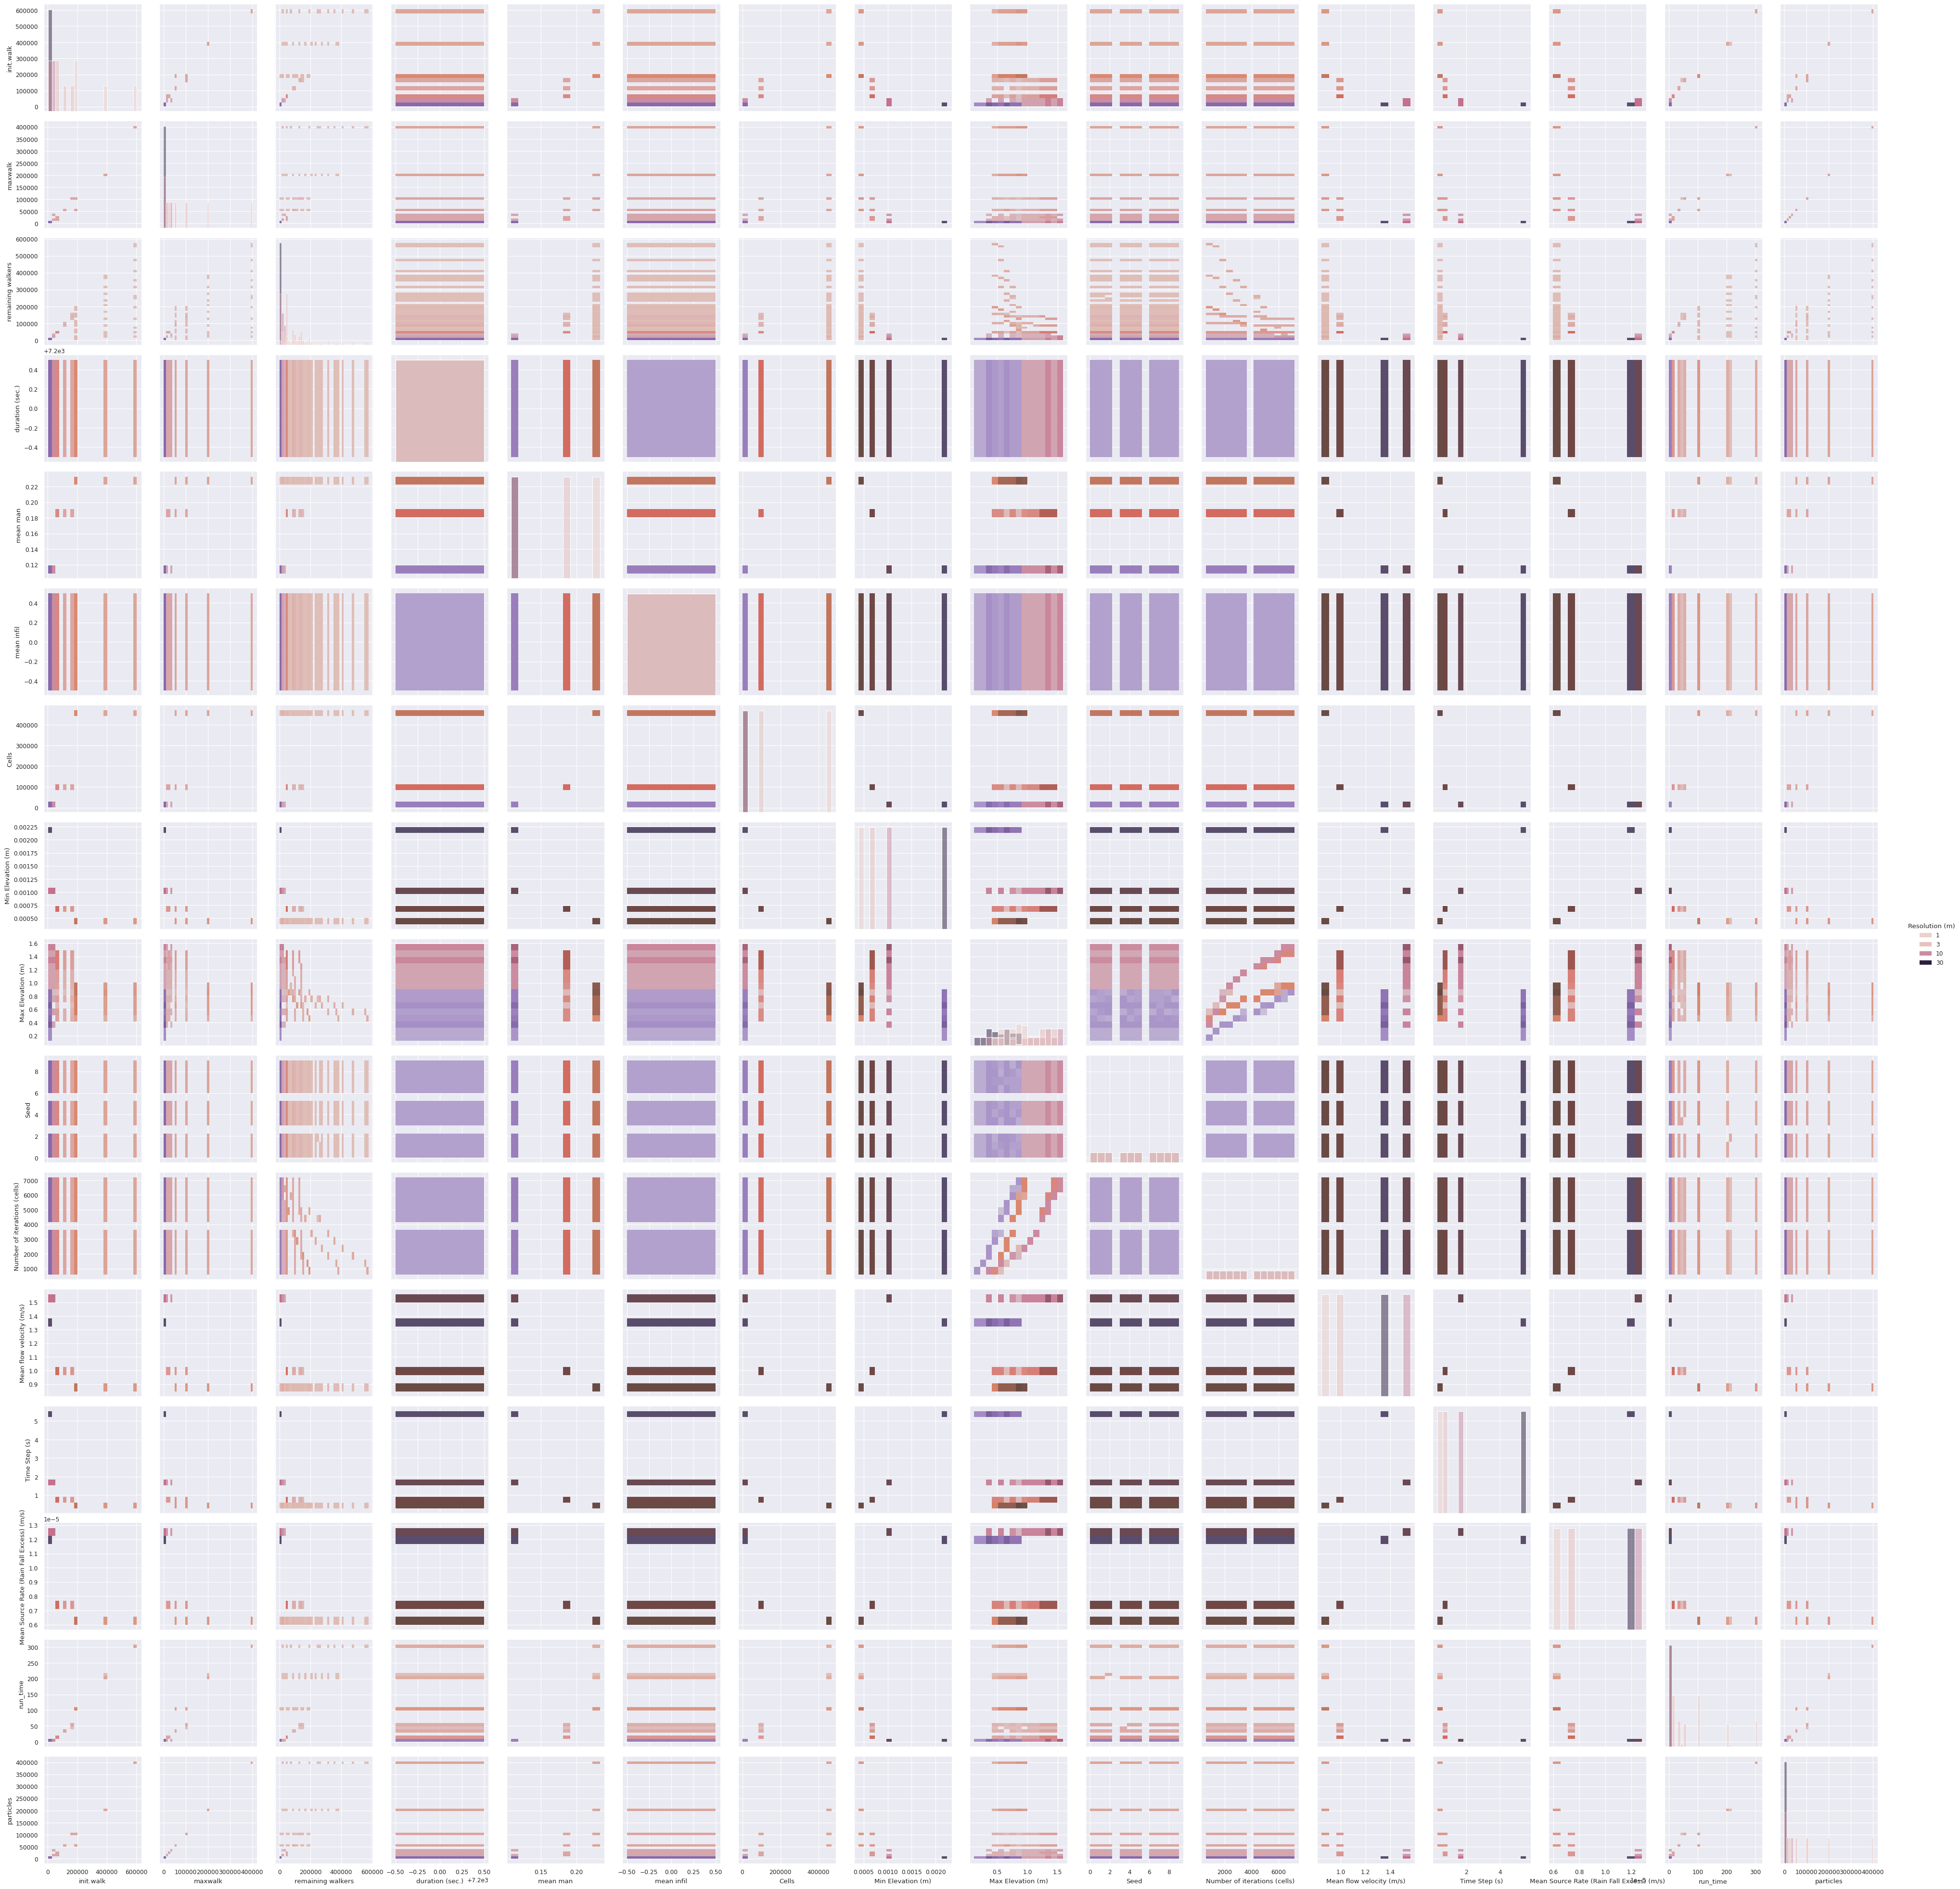

In [123]:
# model_runs_df.info()
sns.pairplot(model_runs_df, hue="Resolution (m)", kind="scatter")

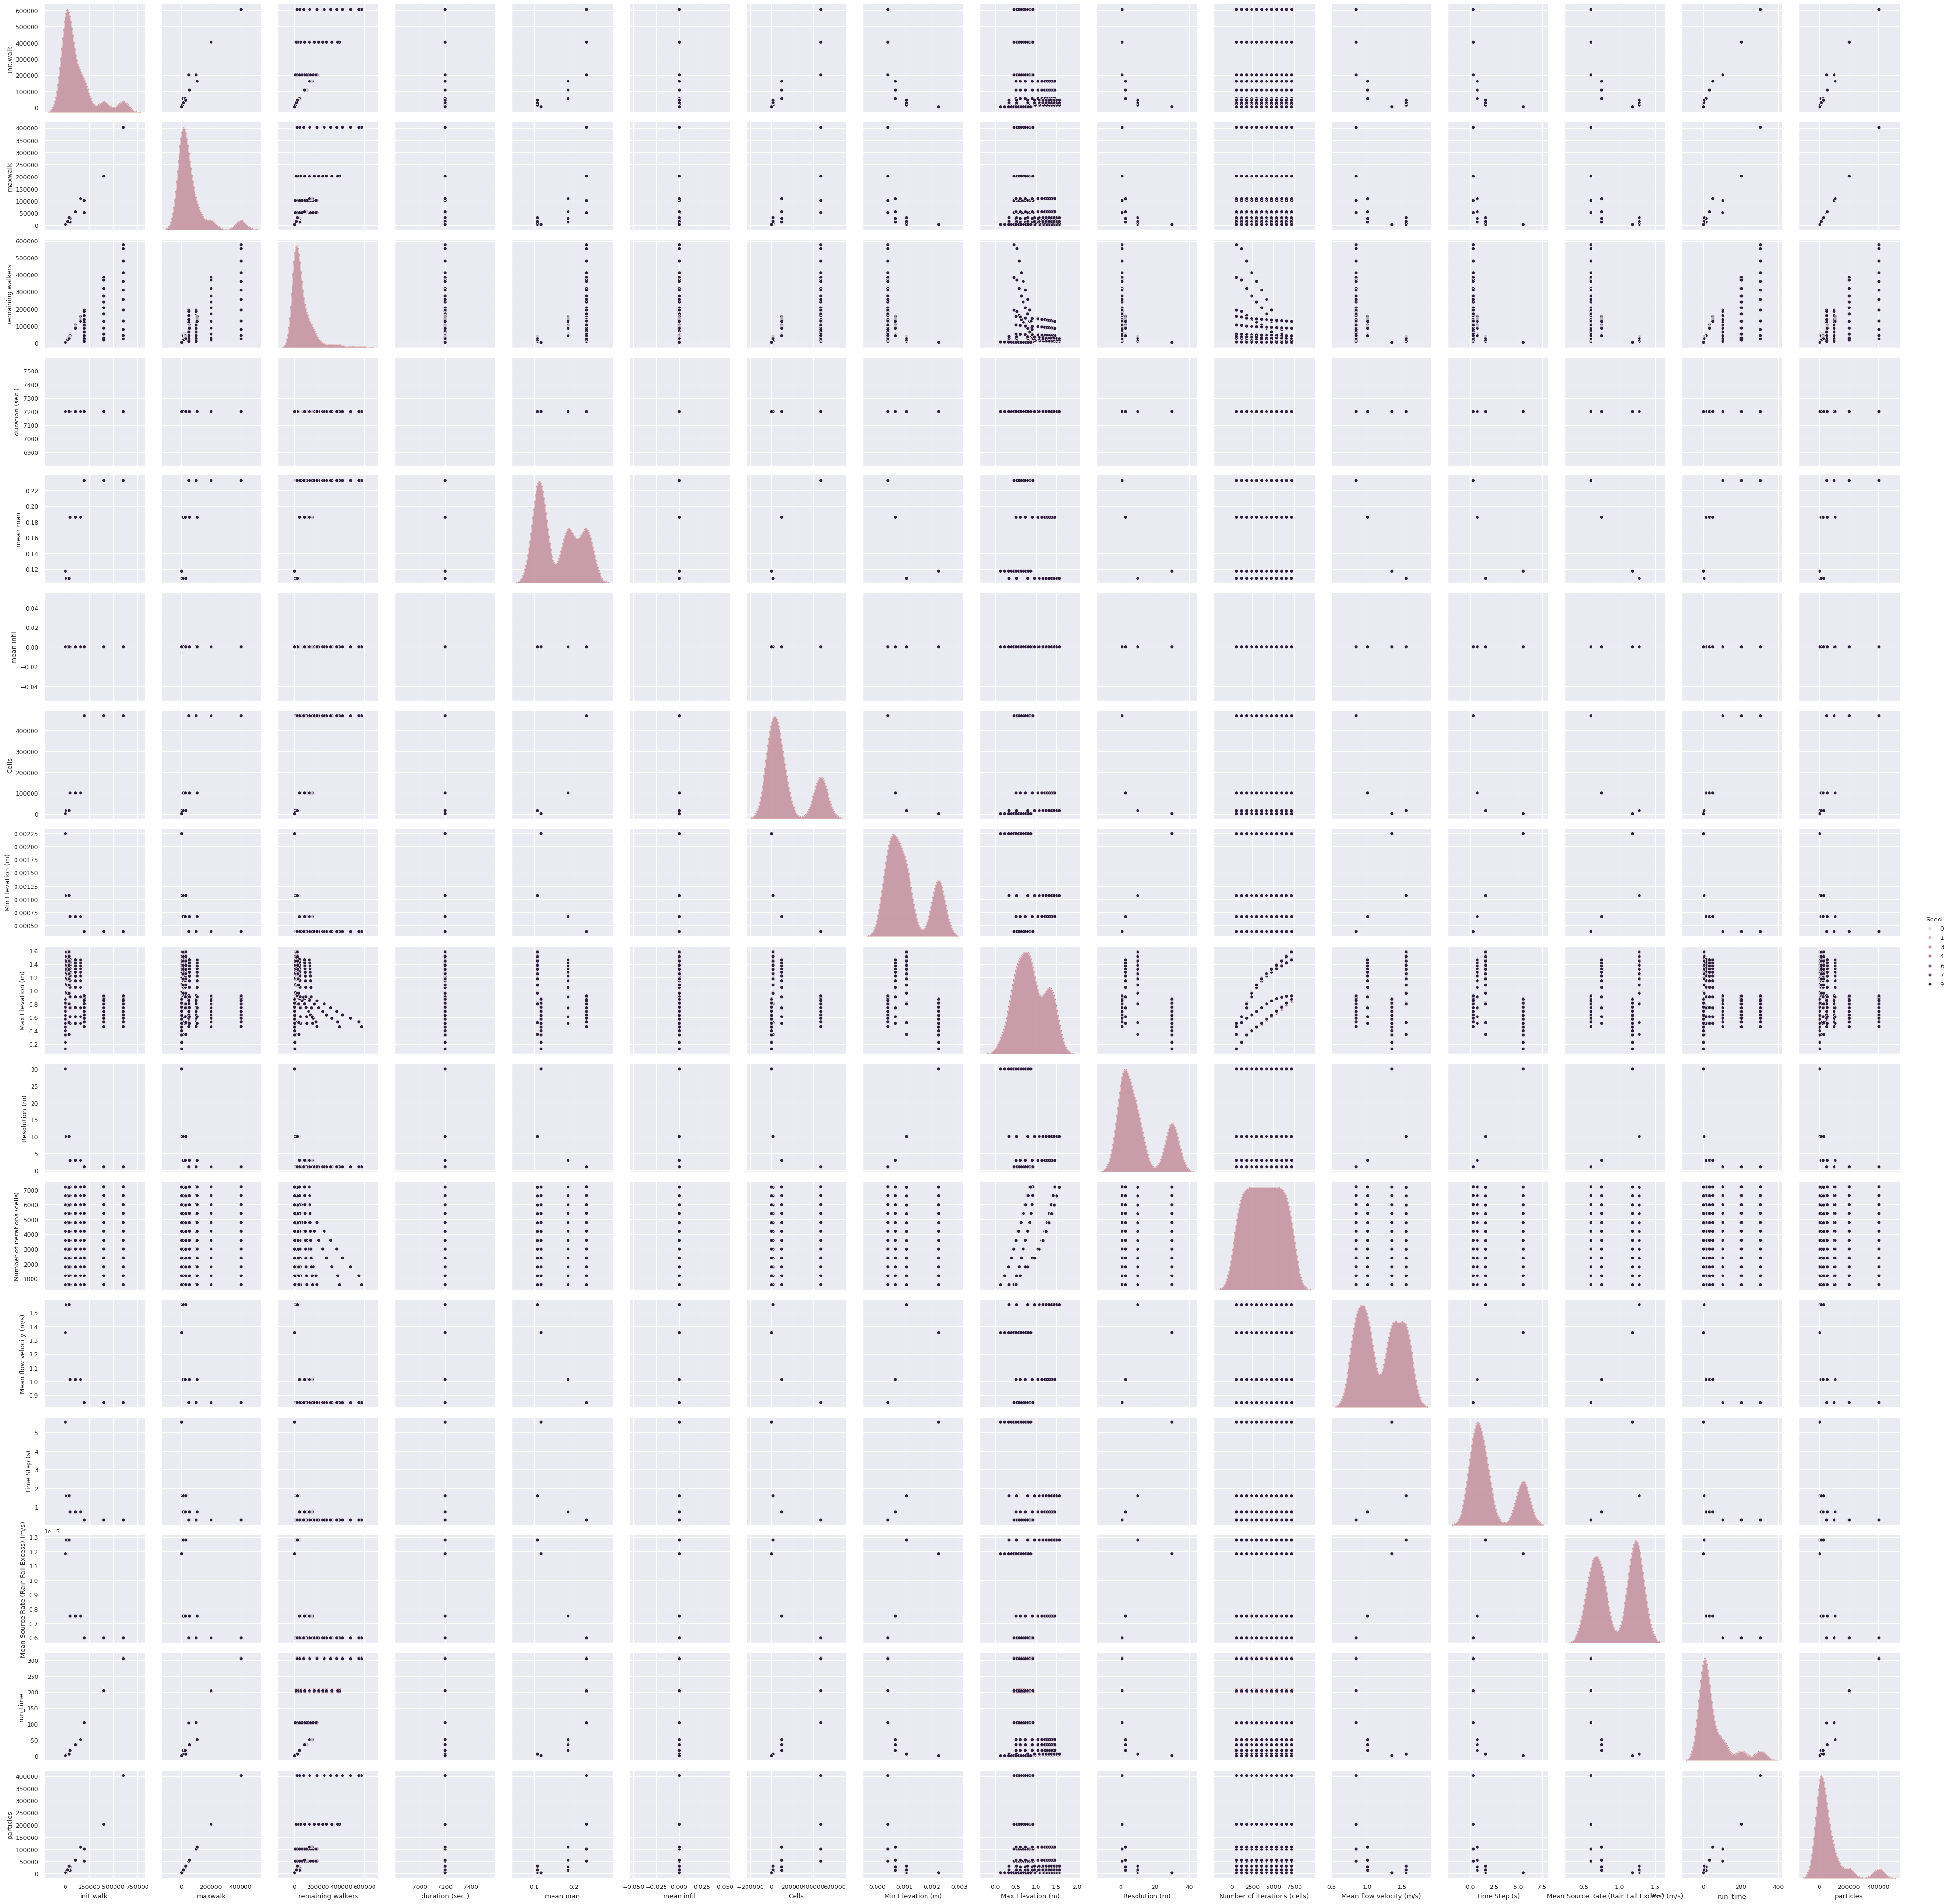

In [124]:
sns.pairplot(model_runs_df, hue="Seed", kind="scatter")


/tmp/ipykernel_414326/3097695937.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


Text(0.5, 1.0, 'Resolution vs Run Time')

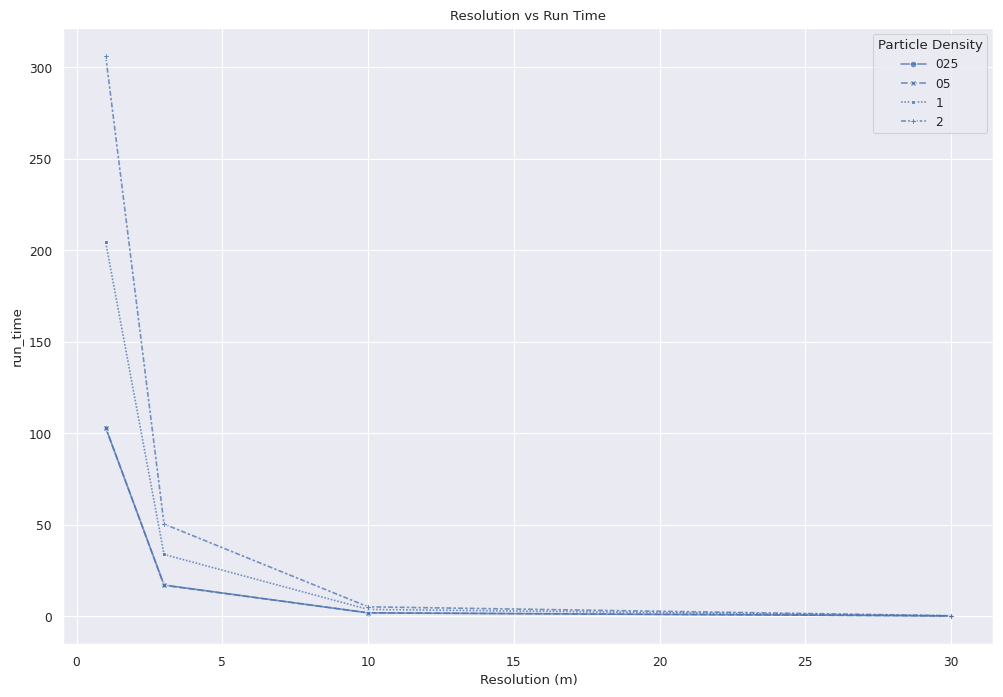

In [119]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=model_runs_df,
    x="Resolution (m)",
    y="run_time",
    # hue="Seed",
    style="Particle Density",
    # size="scalar",
    err_style="bars",
    # errorbar=("se", 2),
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 90),
)

plt.title("Resolution vs Run Time")

Text(0.5, 1.0, 'Particles vs Run Time')

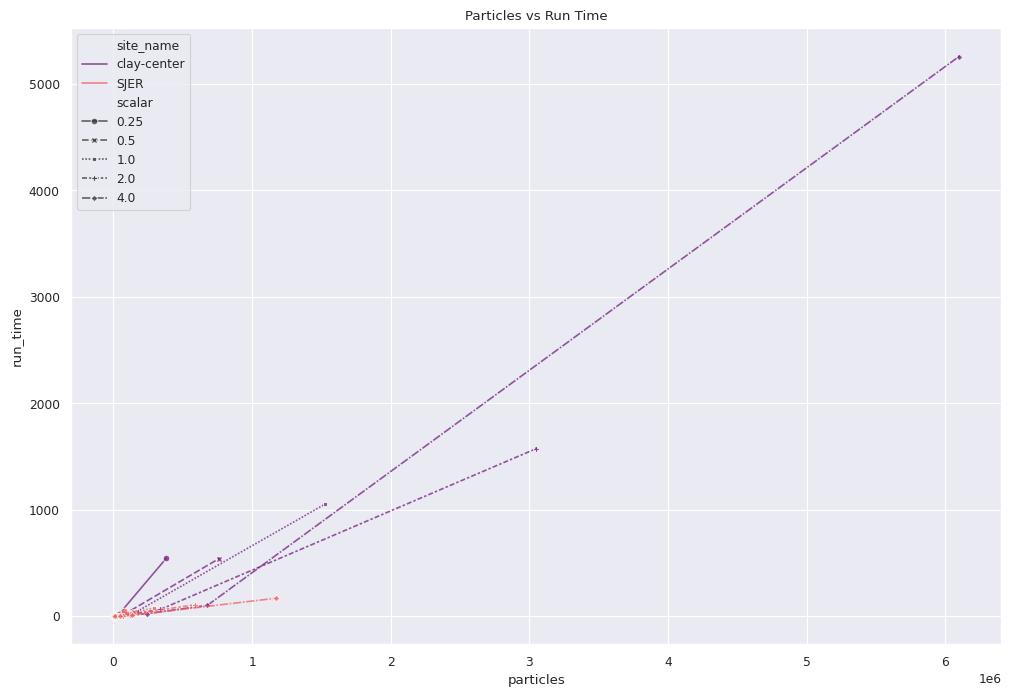

In [13]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=model_runs_df,
    x="particles",
    y="run_time",
    hue="site_name",
    style="scalar",
    # size="scalar",
    err_style="bars",
    # errorbar=("se", 2),
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Run Time")

In [ ]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=model_runs_df,
    x="particles",
    y="run_time",
    hue="site_name",
    style="scalar",
    # size="scalar",
    err_style="bars",
    # errorbar=("se", 2),
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Run Time")

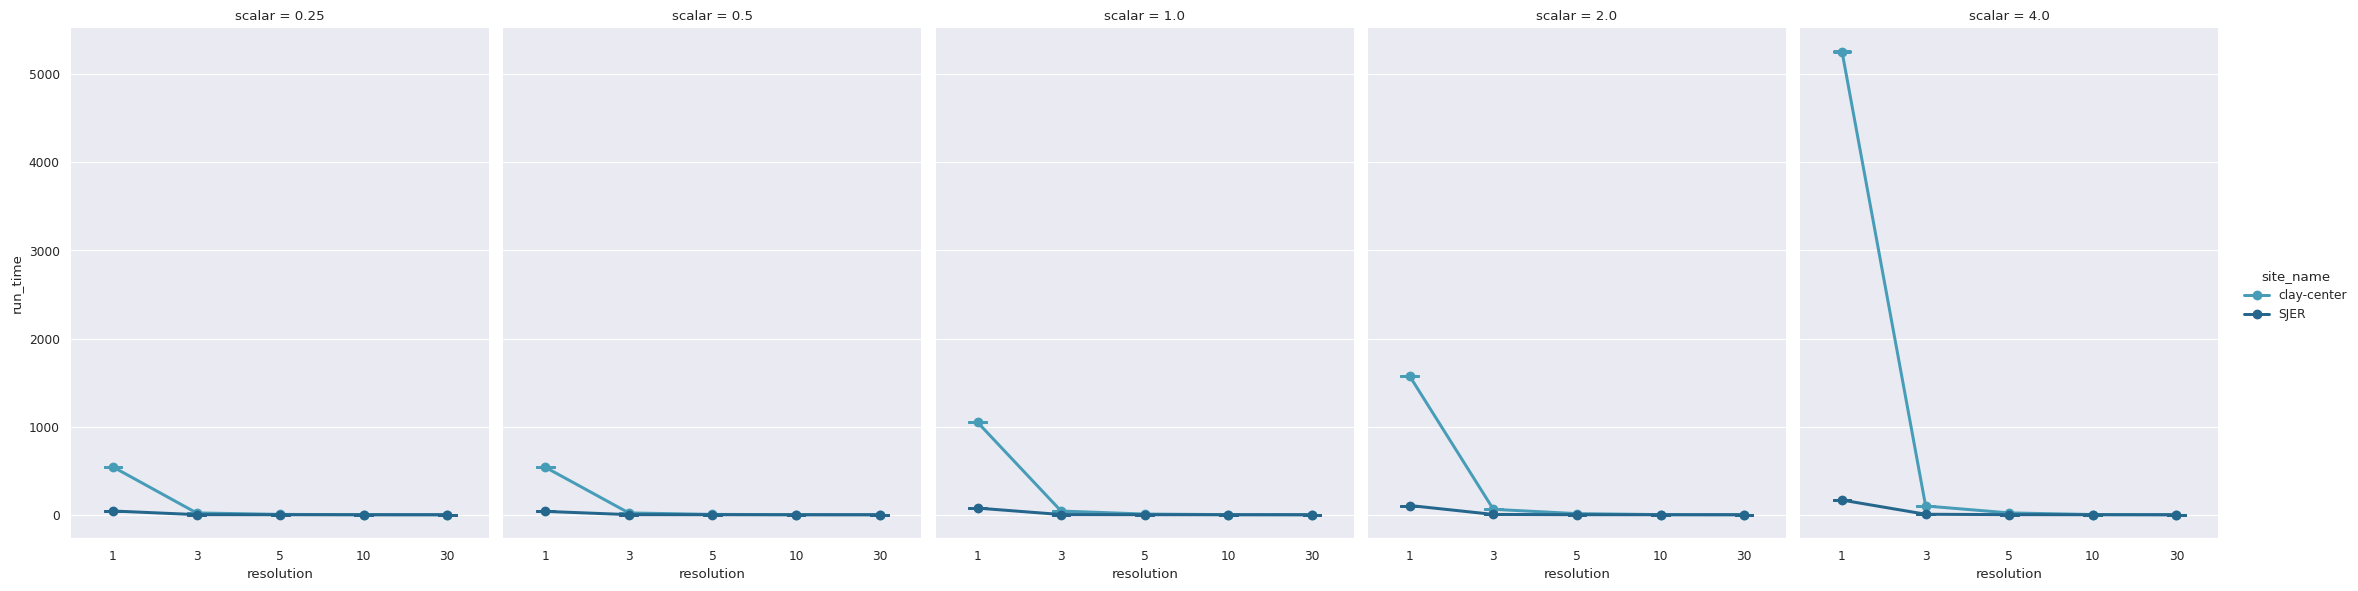

In [16]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
g = sns.catplot(
    data=model_runs_df, x="resolution", y="run_time", hue="site_name", col="scalar",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [27]:
grouped_results_df = (results_df.groupby(by=['resolution', 'scalar', 'site_name', 'stat_type', 'minute'])
        .agg({
            'run_time': 'mean',
            'particles': 'mean',
            'cells': 'mean',
            # 'area_km2': 'max',
            # 'p_density': 'max',
            # "minute": "mean",
            'mean': "mean",
            'ars': "mean",
            "std": "mean",
            "max": "mean",
            "min": "mean",
            "stddev": "mean"
        })
        .reset_index()
)

grouped_results_df['log10(particles)'] = np.log10(grouped_results_df['particles'])
grouped_results_df['log10(run_time)'] = np.log10(grouped_results_df['run_time'])
grouped_results_df['run_time_min'] = grouped_results_df['run_time'] / 60.0
grouped_results_df.head()

resolution scalar site_name stat_type minute   run_time  particles  \
0           1    025      SJER   average     05  42.592428    73398.0   
1           1    025      SJER   average     10  42.592428    73398.0   
2           1    025      SJER   average     15  42.592428    73398.0   
3           1    025      SJER   average     20  42.592428    73398.0   
4           1    025      SJER   average     25  42.592428    73398.0   

      cells      mean       ars       std       max  min    stddev  \
0  701111.0  0.007812  0.358971  7.959114  0.454589  0.0  0.017521   
1  701111.0  0.009153  0.358971  7.959114  0.674124  0.0  0.026979   
2  701111.0  0.009892  0.358971  7.959114  0.827124  0.0  0.032020   
3  701111.0  0.010237  0.358971  7.959114  0.880923  0.0  0.034347   
4  701111.0  0.010349  0.358971  7.959114  0.898901  0.0  0.035123   

   log10(particles)  log10(run_time)  run_time_min  
0          4.865684         1.629332      0.709874  
1          4.865684         1.629332      0.709874  
2          4.865684         1.629332      0.709874  
3          4.865684         1.629332      0.709874  
4          4.865684         1.629332      0.709874

In [28]:
grouped_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   resolution        2392 non-null   int64  
 1   scalar            2392 non-null   object 
 2   site_name         2392 non-null   object 
 3   stat_type         2392 non-null   object 
 4   minute            2392 non-null   object 
 5   run_time          2392 non-null   float64
 6   particles         2392 non-null   float64
 7   cells             2392 non-null   float64
 8   mean              2392 non-null   float64
 9   ars               2160 non-null   float64
 10  std               2392 non-null   float64
 11  max               2392 non-null   float64
 12  min               2392 non-null   float64
 13  stddev            2392 non-null   float64
 14  log10(particles)  2392 non-null   float64
 15  log10(run_time)   2392 non-null   float64
 16  run_time_min      2392 non-null   float64


Text(0.5, 1.0, 'Resolution vs Run Time')

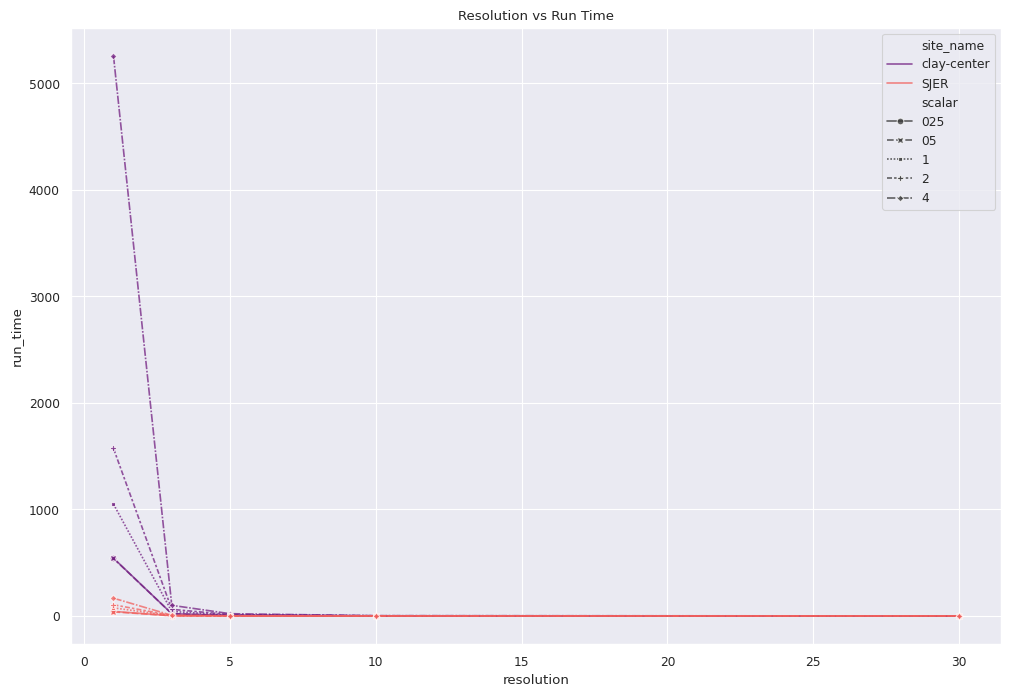

In [29]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x="resolution",
    y="run_time",
    hue="site_name",
    style="scalar",
    # size="scalar",
    err_style="bars", errorbar=("se", 2),
    palette="magma",
    markers=True,
    alpha=0.75,
    # errorbar=('ci', 95),
)
plt.title("Resolution vs Run Time")

In [30]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x="scalar",
    y="run_time",
    hue="site_name",
    style="resolution",
    # size="scalar",
    err_style="bars", #errorbar=("se", 2),
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles Density vs Run Time")
# plt.savefig(f"../output/agu2024_particles_run_time.png")

Text(0.5, 1.0, 'Particles Density vs Run Time')

Text(0.5, 1.0, 'Particles Density vs Run Time')

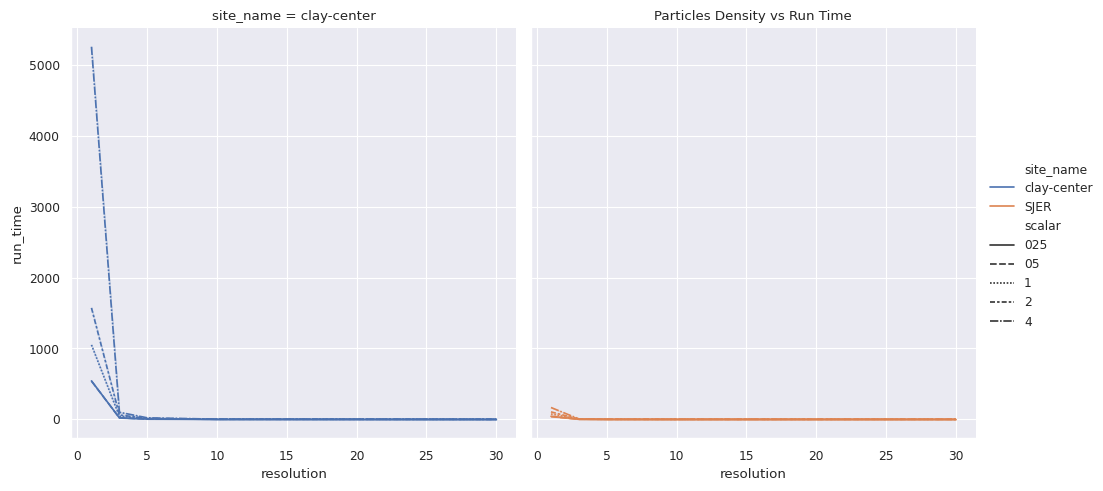

In [47]:

sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
# fig, ax = plt.subplots(figsize=(12, 8))
sns.relplot(
    data=results_df, x="resolution", y="run_time",
    col="site_name", 
    hue="site_name", style="scalar",
    kind="line"
)


# sns.lineplot(
#     data=grouped_results_df,
#     x="scalar",
#     y="run_time",
#     hue="site_name",
#     style="resolution",
#     # size="scalar",
#     err_style="bars", #errorbar=("se", 2),
#     palette="magma",
#     markers=True,
#     alpha=0.75,
#     errorbar=('ci', 95),
# )
plt.title("Particles Density vs Run Time")

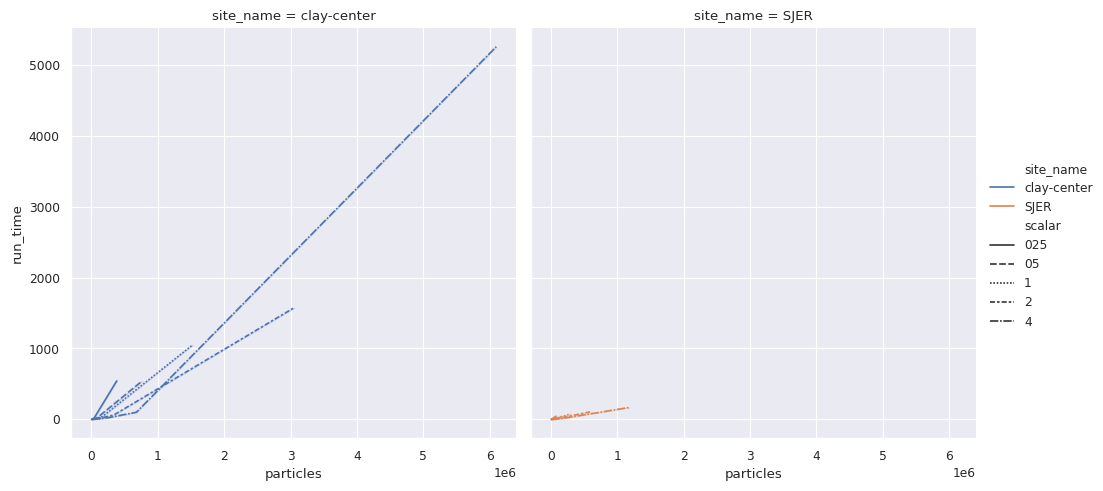

In [50]:
sns.relplot(
    data=results_df, x="particles", y="run_time",
    col="site_name", 
    hue="site_name", style="scalar",
    kind="line"
)

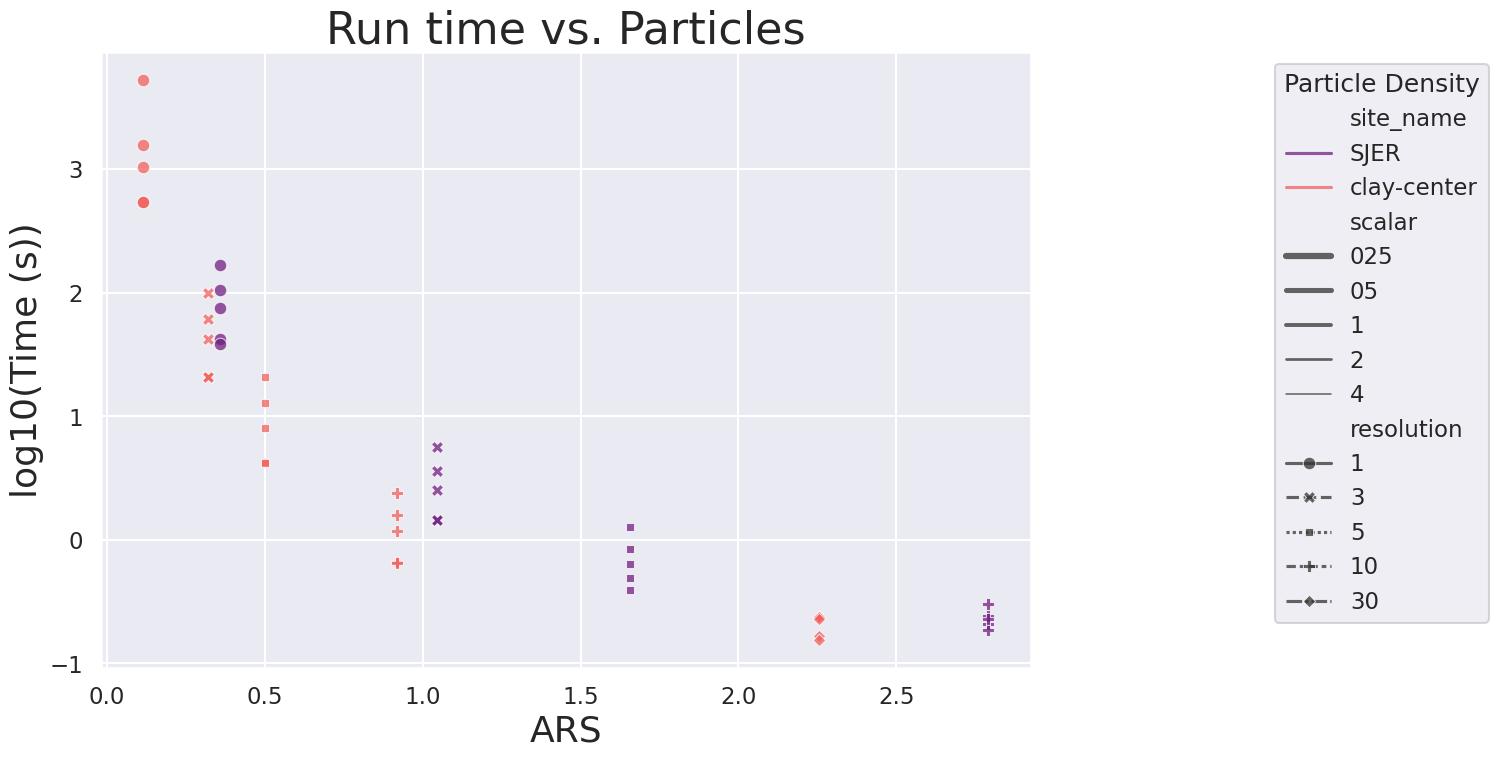

In [54]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
# sns.lineplot(
#     data=grouped_results_df.query("stat_type == 'average'"),
#     # x="p_density",
#     x="ars",
#     y="max",
#     # y="run_time_min",
#     hue="site_name",
#     size="scalar",
#     palette="crest_r",
#     markers=True,
#     # style='resolution',
#     alpha=0.75,
#     errorbar=('ci', 95)
# )



# ax2 = plt.twinx()

sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    # x="p_density",
    x="ars",
    y="log10(run_time)",
    # y="run_time_min",
    hue="site_name",
    size="scalar",
    palette="magma",
    markers=True,
    style='resolution',
    alpha=0.75,
    errorbar=('ci', 95),
    # ax=ax2
)
plt.xlabel("ARS", fontsize=26)
plt.ylabel("log10(Time (s))", fontsize=26)
plt.title("Run time vs. Particles", fontsize=32)
plt.legend(title="Particle Density", fontsize=18)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.25,1))
# sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.25,0.25))
# ax2.set_ylabel("Resolution (m)", fontsize=26)

# plt.savefig(os.path.join("../output", site, mapset, f'{site}_run_time_res_line_plot.png'))

# plt.savefig(f"../output/{site}/{mapset}/{site}_run_time_res_line_plot.png")
plt.show()

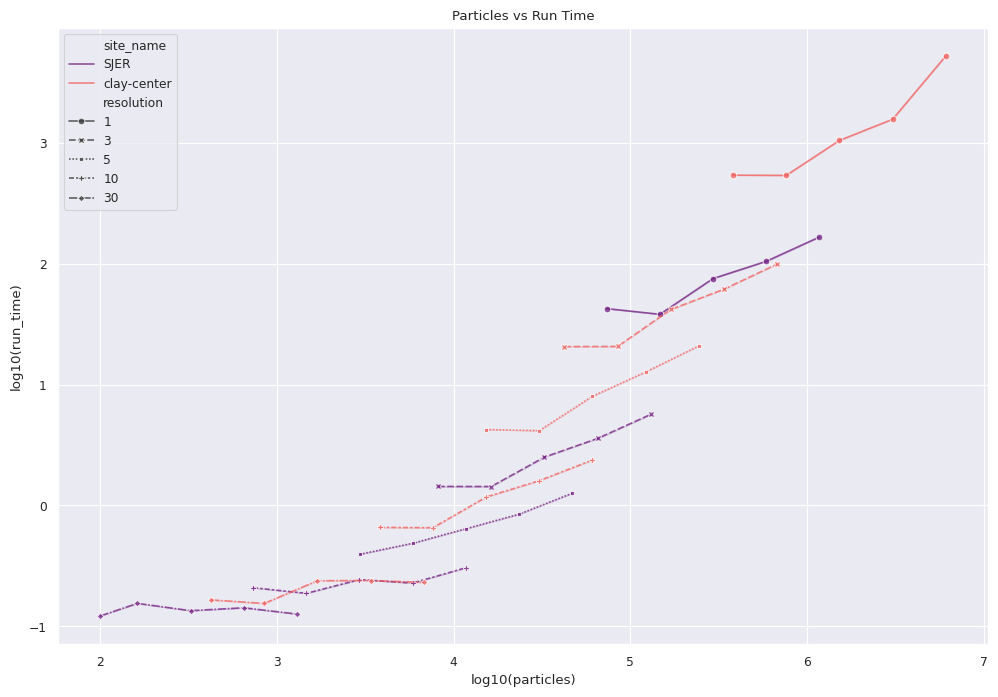

In [33]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df,
    x="log10(particles)",
    y="log10(run_time)",
    hue="site_name",
    # size="resolution",
    style="resolution",
    # weights="error",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Run Time")
plt.savefig(f"../output/agu2024_particles_run_time.png")


In [34]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df,
    x="cells",
    y="log10(particles)",
    hue="site_name",
    style="scalar",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Resolution")
# plt.savefig(f"../output/agu2024_particles_resolution.png")

Text(0.5, 1.0, 'Particles vs Resolution')

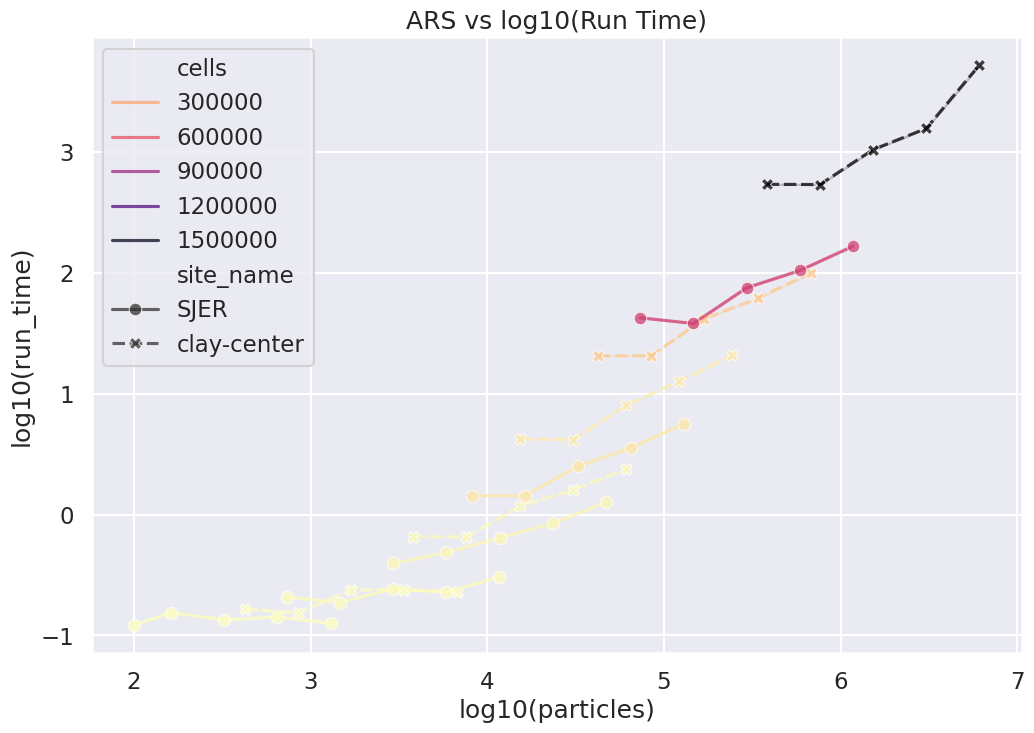

In [35]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x="log10(particles)",
    y="log10(run_time)",
    hue="cells",
    style="site_name",
    # size="scalar",
    palette="magma_r",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("ARS vs log10(Run Time)")
plt.savefig(f"../output/agu2024_ars_run_time.png")

Text(0.5, 1.0, 'log10(particles) by Max Depth')

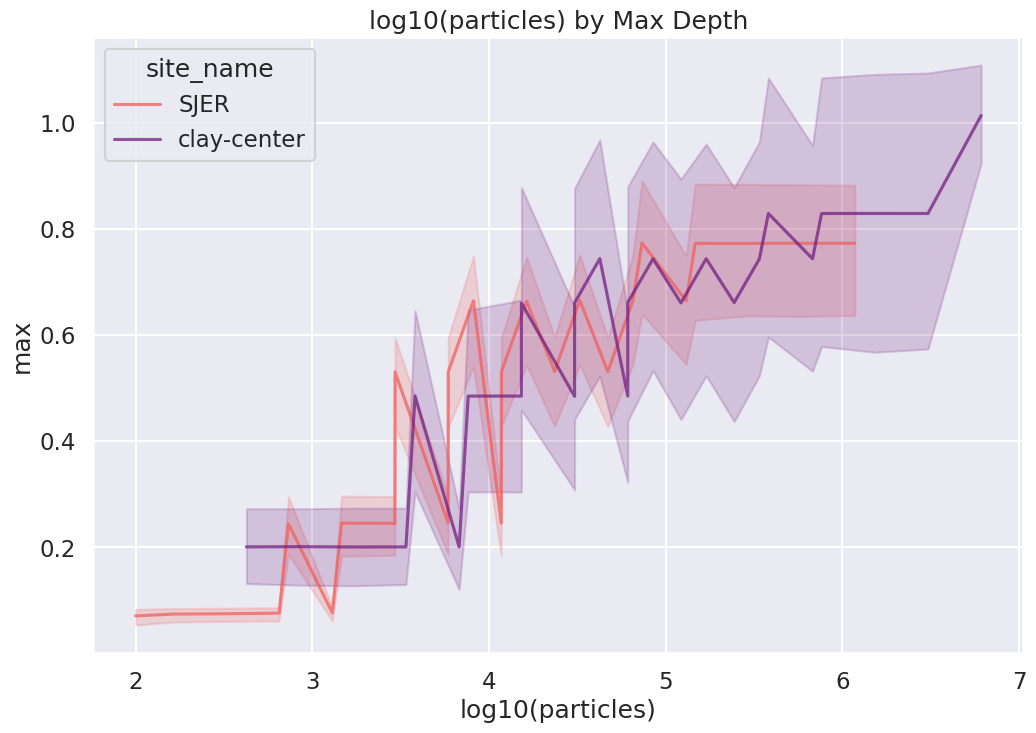

In [36]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x="log10(particles)",
    y="max",
    hue="site_name",
    # style="minute",
    palette="magma_r",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("log10(particles) by Max Depth")

In [37]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x=grouped_results_df.query("stat_type == 'average'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    style="resolution",
    size="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Mean Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_mean_resolution.png")

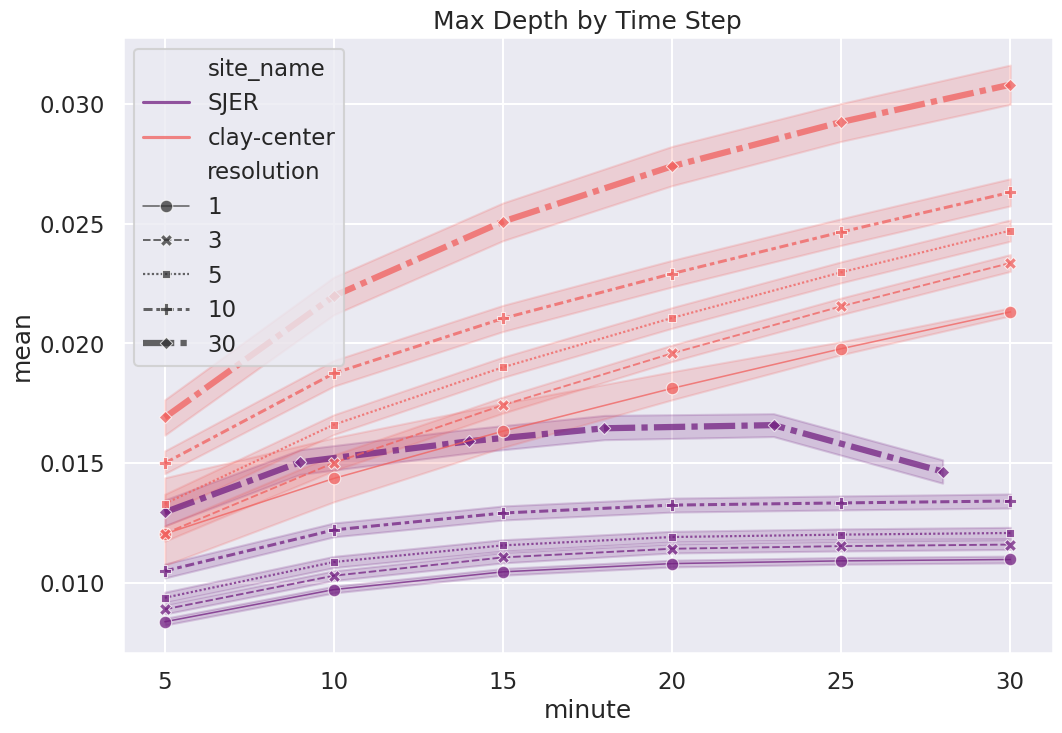

In [38]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'maximum'"),
    x=grouped_results_df.query("stat_type == 'maximum'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    size="resolution",
    style="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Max Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_max_resolution.png")

In [40]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'minimum'"),
    x=grouped_results_df.query("stat_type == 'minimum'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    style="resolution",
    size="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Min Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_min_resolution.png")

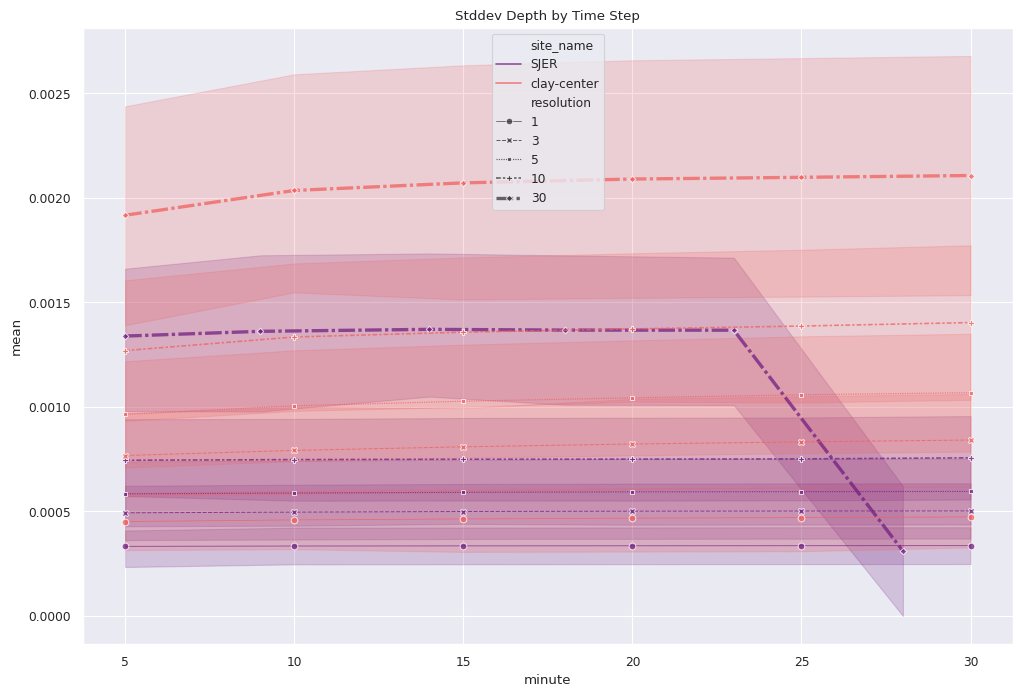

In [41]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'stddev'"),
    x=grouped_results_df.query("stat_type == 'stddev'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    style="resolution",
    size="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Stddev Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_std_resolution.png")

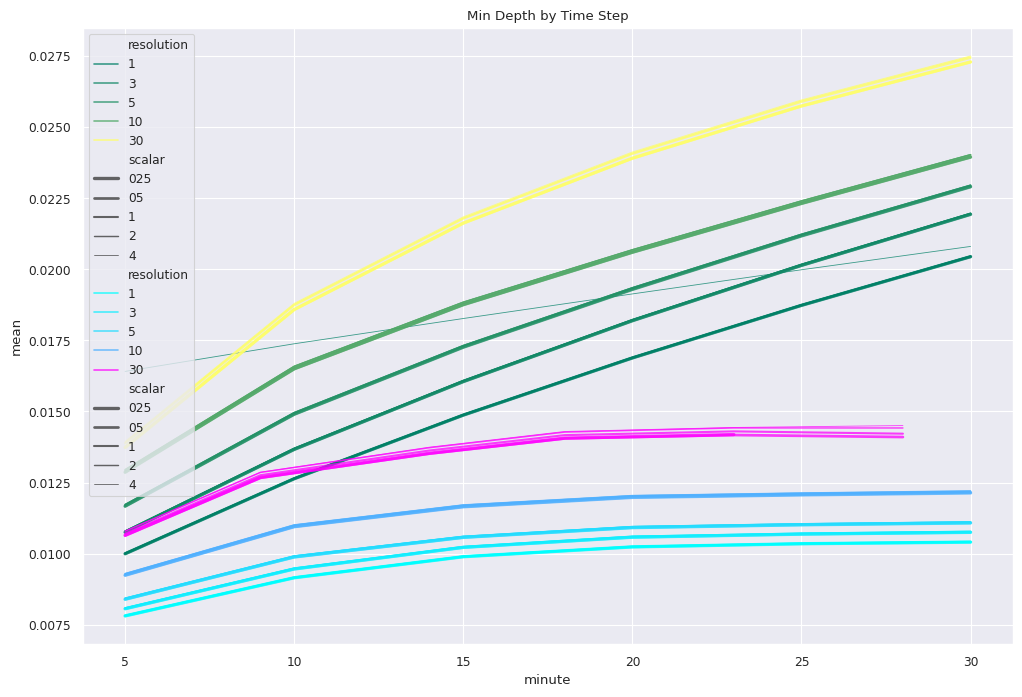

In [42]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average' & site_name == 'clay-center'"),
    x=grouped_results_df.query("stat_type == 'average' & site_name == 'clay-center'")["minute"].astype(int),
    y="mean",
    hue="resolution",
    # style="resolution",
    size="scalar",
    palette="summer",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average' & site_name == 'SJER'"),
    x=grouped_results_df.query("stat_type == 'average' & site_name == 'SJER'")["minute"].astype(int),
    y="mean",
    hue="resolution",
    # style="scalar",
    size="scalar",
    palette="cool",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Min Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_average_scalar.png")